# Project 65: Convolutional neural networks for text classification

### Author:  Julen Miner Goñi

### Objectives:

-  use convolutional neural networks to classify different (text) documents in 20 classes.

### What is done in the Notebook: 

-  collect the data from the files
-  preprocess the data (using word embeddings)
-  implement a CNN and train with the train data
-  show the results of the training
-  analyze and contrast the results of the testing

The data and models files can be downloaded from my GitHub:
- https://github.com/julenminer/mlnn_P65.git

The word embedding files can be downloaded from the links that are given below.

## Importing the libraries

In [1]:
# General and preproccesing of the data
import numpy as np
import os, pickle, re, string

# Preprocessing and processing of the data
from nltk.corpus import stopwords
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split

# To show the plots
import matplotlib.pyplot as plt

# Processing of the data
from keras.layers import Activation, Input, Dense, Dropout, Embedding
import gensim
from keras.layers.convolutional import SeparableConv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras import initializers
from keras import backend as K

# Preprocessing of the data. The first time that the model is executed, the stopwords
# have to be downloaded, otherwise, theya won't be downloaded as it is already done
import nltk
nltk.download('stopwords')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /Users/julen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Defining of parameters
Some initial parameters defined for this project.

In [2]:
# Maximum number of words
MAX_NUM_WORDS   = 15000
# Dimenstion of the word embedding
EMBEDDING_DIM   = 300
# Maximum length for the vectors
# This number was selected as the mean length is 273
MAX_SEQ_LENGTH  = 500

# For the CNN and the data
FILTER_SIZES    = [3,4,5]
FEATURE_MAPS    = [200,200,200]
DROPOUT_RATE    = 0.4
HIDDEN_UNITS    = 200
NB_CLASSES      = 20

# LEARNING
BATCH_SIZE      = 100
NB_EPOCHS_SMALL = 10
NB_EPOCHS       = 40
VAL_SIZE        = 0.2

## Preprocessing of the data

### Functions for the files
These functions are used to obtain the strings from the files and clean them.

In [3]:
# This function lowercases the text, removes extra whitespaces,
# stopwords, punctuations and short words 
def clean_doc(doc):
    # Define the english stopwords
    stop_words = set(stopwords.words('english'))
    # Lowercase
    doc = doc.lower()
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words] 
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

# This function, given a path, reads all of the documents that are in it
def read_files(path):
    documents = list()
    # Read in all files in directory
    if os.path.isdir(path):
        for filename in os.listdir(path):
            with open('%s/%s' % (path, filename)) as f:
                doc = f.read()
                doc = clean_doc(doc)
                documents.append(doc)
    
    # Read in all lines in a txt file
    if os.path.isfile(path):        
        with open(path, encoding='utf-8') as f:
            doc = f.readlines()
            for line in doc:
                documents.append(clean_doc(line))
    return documents

### Getting the text from the files

All of the files are loaded and stored in individual variables. Then, the labels are computed using the length of the previously computed variables.

In [4]:
# Load the files from the folders
doc1 = read_files("./data/20news-bydate-train/alt.atheism")
doc2 = read_files("./data/20news-bydate-train/comp.graphics")
doc3 = read_files("./data/20news-bydate-train/comp.os.windows.misc")
doc4 = read_files("./data/20news-bydate-train/comp.sys.ibm.pc.hardware")
doc5 = read_files("./data/20news-bydate-train/comp.sys.mac.hardware")
doc6 = read_files("./data/20news-bydate-train/comp.windows.x")
doc7 = read_files("./data/20news-bydate-train/misc.forsale")
doc8 = read_files("./data/20news-bydate-train/rec.autos")
doc9 = read_files("./data/20news-bydate-train/rec.motorcycles")
doc10 = read_files("./data/20news-bydate-train/rec.sport.baseball")
doc11 = read_files("./data/20news-bydate-train/rec.sport.hockey")
doc12 = read_files("./data/20news-bydate-train/sci.crypt")
doc13 = read_files("./data/20news-bydate-train/sci.electronics")
doc14 = read_files("./data/20news-bydate-train/sci.med")
doc15 = read_files("./data/20news-bydate-train/sci.space")
doc16 = read_files("./data/20news-bydate-train/soc.religion.christian")
doc17 = read_files("./data/20news-bydate-train/talk.politics.guns")
doc18 = read_files("./data/20news-bydate-train/talk.politics.mideast")
doc19 = read_files("./data/20news-bydate-train/talk.politics.misc")
doc20 = read_files("./data/20news-bydate-train/talk.religion.misc")

# Join all of the documents
docs   = doc1 + doc2 + doc3 + doc4 + doc5 + doc6 + doc7 + doc8 + doc9 + \
    doc10 + doc11 + doc12 + doc13 + doc14 + doc15 + doc16 + doc17 + doc18 + doc19 + doc20

# Assign the corresponding labels 
labels = [0 for _ in range(len(doc1))] + [1 for _ in range(len(doc2))] + [2 for _ in range(len(doc3))] \
    + [3 for _ in range(len(doc4))] + [4 for _ in range(len(doc5))] + [5 for _ in range(len(doc6))] \
    + [6 for _ in range(len(doc7))] + [7 for _ in range(len(doc8))] + [8 for _ in range(len(doc9))] \
    + [9 for _ in range(len(doc10))] + [10 for _ in range(len(doc11))] + [11 for _ in range(len(doc12))] \
    + [12 for _ in range(len(doc13))] + [13 for _ in range(len(doc14))] + [14 for _ in range(len(doc15))] \
    + [15 for _ in range(len(doc16))] + [16 for _ in range(len(doc17))] + [17 for _ in range(len(doc18))] \
    + [18 for _ in range(len(doc19))] + [19 for _ in range(len(doc20))]

# This function converts a class vector (integers) to binary class matrix.
# This is to use categorical crossentropy later.
labels = to_categorical(labels)
print('Training samples: %i' % len(docs))

Training samples: 10723


### Tokenization of the sentences

Thanks to his, the text of the documents will be vectorized, each word will be in a position of an array. The word index is also computed (also called dictionary), each word will have a number assigned. This is used lated for the embedding layers.

In [5]:
# Create a tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# Tokenize all the documents
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)

# Obtain the word index
word_index = tokenizer.word_index

# Print some information of the documents
result = [len(x.split()) for x in docs]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of 'MAX_SEQ_LENGTH'
data = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 7055 / min length: 12 / mean length: 168 / limit length: 500
vacobulary size: 118469 / limit: 15000


### Word embeddings

The following two functions will be used to load the embeddings index from the vectors that are on a given path and to load the embedding matrix (used to create the embedding layer) given an embeddings index.

In [6]:
# Given a path, this function will read all the lines
# and store the value of each word in the embeddings index
def load_vector(path):
    embeddings_index = {}
    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

# Given a embeddings index, this function will compute
# the embedding matrix of all the words in the word index (dictionary)
def load_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        try:
            embedding_vector = embeddings_index[word]
        except:
            # If a word is not found, the value will be None
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

The file of the GloVe embeddings can be downloaded from:
- http://nlp.stanford.edu/data/glove.6B.zip

The download will start when you click the link.

In [7]:
print('Loading GloVe pretrained embeddings')

# Load the GloVe embedding
embeddings_index_glove = load_vector('embeddings/glove.6B.%id.txt' % EMBEDDING_DIM)
embedding_matrix_glove = load_embedding_matrix(embeddings_index_glove)

# Create the embedding layer for the GloVe embedding matrix
embedding_layer_glove = Embedding(
    input_dim=MAX_NUM_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQ_LENGTH,
    weights=[embedding_matrix_glove],
    trainable=True,
    name="word_embedding"
)

Loading GloVe pretrained embeddings


The file of the Google's word2vec embeddings can be downloaded from:
- https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

The download will start when you click the link.

In [8]:
print('Loading Google\'s word2vec pretrained embeddings')

# Load Google's vector using gensim word2vec 
embeddings_index_google = gensim.models.KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin', binary=True)  
embedding_matrix_google = load_embedding_matrix(embeddings_index_google)

# Create the embedding layer for Google's embedding matrix
embedding_layer_google = Embedding(
    input_dim=MAX_NUM_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQ_LENGTH,
    weights=[embedding_matrix_google],
    trainable=True,
    name="word_embedding"
)

Loading Google's word2vec pretrained embeddings


The file of the FastText's WikiNews embeddings can be downloaded from:
- https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip

The download will start when you click the link.

In [9]:
print('Loading FastText\'s WikiNews pretrained embeddings')

# Load the WikiNews embedding
embeddings_index_wikinews = load_vector('embeddings/wiki-news-300d-1M.vec')
embedding_matrix_wikinews = load_embedding_matrix(embeddings_index_wikinews)

# Create the embedding layer for the WikiNews embedding matrix
embedding_layer_wikinews = Embedding(
    input_dim=MAX_NUM_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQ_LENGTH,
    weights=[embedding_matrix_wikinews],
    trainable=True,
    name="word_embedding"
)

Loading FastText's WikiNews pretrained embeddings


The file of the FastText's WikiNews embeddings can be downloaded from:
- https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M.vec.zip

The download will start when you click the link.

In [10]:
print('Loading FastText\'s Crawl pretrained embeddings')

# Load the Crawl embedding
embeddings_index_crawl = load_vector('embeddings/crawl-300d-2M.vec')
embedding_matrix_crawl = load_embedding_matrix(embeddings_index_crawl)

# Create the embedding layer for the Crawl embedding matrix
embedding_layer_crawl = Embedding(
    input_dim=MAX_NUM_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQ_LENGTH,
    weights=[embedding_matrix_crawl],
    trainable=True,
    name="word_embedding"
)

Loading FastText's Crawl pretrained embeddings


## Processing of the data

### Definition of the model

The following three functions are used to create the convolutional neural networks. The function that is used later is the one named create_model. This function has the embedding layer as a parameter, since that is going to be the main difference of the models.

In [11]:
# Creates several CNN channels and concatenate them
def building_block(input_layer, filter_sizes, feature_maps):
    channels = []
    for ix in range(len(FILTER_SIZES)):
        x = create_channel(input_layer, filter_sizes[ix], feature_maps[ix])
        channels.append(x)

    # Checks how many channels, one channel doesn't need a concatenation
    if (len(channels)>1):
        x = concatenate(channels)
    return x


# Creates a layer
def create_channel(x, filter_size, feature_map):
    x = SeparableConv1D(feature_map, kernel_size=filter_size, activation='relu', strides=1, padding='same',
                        depth_multiplier=4)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(HIDDEN_UNITS)(x)
    x = Dropout(DROPOUT_RATE)(x)
    return x

# Creates the model
def create_model(embedding_layer):
    # Defines the input of the model
    word_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name='word_input')
    # Defines the first embedding layer that has the previously defined word input as input
    x = embedding_layer(word_input)
    x = Dropout(DROPOUT_RATE)(x)
    x = building_block(x, FILTER_SIZES, FEATURE_MAPS)
    x = Activation('relu')(x)
    prediction = Dense(NB_CLASSES, activation='softmax')(x)
    model = Model(inputs=word_input, outputs=prediction)
    return model

### Training of the models with 10 epochs

In this section, four models are created with different embedding layers. The training of this models is done with 10 epochs.

In [61]:
# Create an array to store the performances of the models
histories_10 = []

The main training data obtained from the documents is divided into train and validation data. The size of the validation data is the 20% of the original training data.

In [62]:
random_state = np.random.randint(1000)

# Dividing between train and validation data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=VAL_SIZE, random_state=random_state)

The four models follow the same instructions:
- the model is created with the corresponding embedding layer
- the model is compiled using categorical crossentropy and Adam Optimizer 
- the training data is fitted in the model in 10 epochs and the validation data is validated
- when the fitting finishes, the model is saved (in order to use it in other moment, it will not be needed to compute again)
- the performance is saved

In [63]:
print('First model, using GloVe word embedding')

model_glove_10 = create_model(embedding_layer_glove)
model_glove_10.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_glove_10.fit(
    X_train, y_train,
    epochs=NB_EPOCHS_SMALL,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_glove_10', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories_10.append(history.history)

First model, using GloVe word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/10
8578/8578 [==============================] - 218s 25ms/step - loss: 2.5248 - acc: 0.2292 - val_loss: 1.5423 - val_acc: 0.5506

Epoch 00001: val_loss improved from inf to 1.54232, saving model to models/model_glove_10
Epoch 2/10
8578/8578 [==============================] - 208s 24ms/step - loss: 1.0890 - acc: 0.6353 - val_loss: 0.7495 - val_acc: 0.7660

Epoch 00002: val_loss improved from 1.54232 to 0.74946, saving model to models/model_glove_10
Epoch 3/10
8578/8578 [==============================] - 211s 25ms/step - loss: 0.6047 - acc: 0.8065 - val_loss: 0.5496 - val_acc: 0.8387

Epoch 00003: val_loss improved from 0.74946 to 0.54956, saving model to models/model_glove_10
Epoch 4/10
8578/8578 [==============================] - 208s 24ms/step - loss: 0.4044 - acc: 0.8732 - val_loss: 0.4472 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.54956 to 0.44722, saving model to models/mod

In [64]:
print('Second model, using Google\'s word2vec word embedding')

model_google_10 = create_model(embedding_layer_google)
model_google_10.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_google_10.fit(
    X_train, y_train,
    epochs=NB_EPOCHS_SMALL,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_google_10', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories_10.append(history.history)

Second model, using Google's word2vec word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/10
8578/8578 [==============================] - 215s 25ms/step - loss: 2.7539 - acc: 0.1697 - val_loss: 1.9064 - val_acc: 0.5254

Epoch 00001: val_loss improved from inf to 1.90641, saving model to models/model_google_10
Epoch 2/10
8578/8578 [==============================] - 207s 24ms/step - loss: 1.2065 - acc: 0.6075 - val_loss: 0.7641 - val_acc: 0.7403

Epoch 00002: val_loss improved from 1.90641 to 0.76407, saving model to models/model_google_10
Epoch 3/10
8578/8578 [==============================] - 207s 24ms/step - loss: 0.6022 - acc: 0.8051 - val_loss: 0.5443 - val_acc: 0.8312

Epoch 00003: val_loss improved from 0.76407 to 0.54431, saving model to models/model_google_10
Epoch 4/10
8578/8578 [==============================] - 207s 24ms/step - loss: 0.3329 - acc: 0.8985 - val_loss: 0.4296 - val_acc: 0.8737

Epoch 00004: val_loss improved from 0.54431 to 0.42964, saving mod

In [65]:
print('Third model, using FastText\'s WikiNews word embedding')

model_wikinews_10 = create_model(embedding_layer_wikinews)
model_wikinews_10.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_wikinews_10.fit(
    X_train, y_train,
    epochs=NB_EPOCHS_SMALL,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_wikinews_10', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories_10.append(history.history)

Third model, using FastText's WikiNews word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/10
8578/8578 [==============================] - 209s 24ms/step - loss: 2.8434 - acc: 0.1321 - val_loss: 2.2190 - val_acc: 0.4107

Epoch 00001: val_loss improved from inf to 2.21897, saving model to models/model_wikinews_10
Epoch 2/10
8578/8578 [==============================] - 208s 24ms/step - loss: 1.2244 - acc: 0.6097 - val_loss: 0.6855 - val_acc: 0.7711

Epoch 00002: val_loss improved from 2.21897 to 0.68550, saving model to models/model_wikinews_10
Epoch 3/10
8578/8578 [==============================] - 209s 24ms/step - loss: 0.4868 - acc: 0.8460 - val_loss: 0.4521 - val_acc: 0.8578

Epoch 00003: val_loss improved from 0.68550 to 0.45213, saving model to models/model_wikinews_10
Epoch 4/10
8578/8578 [==============================] - 208s 24ms/step - loss: 0.2269 - acc: 0.9358 - val_loss: 0.3822 - val_acc: 0.8858

Epoch 00004: val_loss improved from 0.45213 to 0.38221, sav

In [66]:
print('Fourth model, using FastText\'s Crawl word embedding')

model_crawl_10 = create_model(embedding_layer_crawl)
model_crawl_10.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_crawl_10.fit(
    X_train, y_train,
    epochs=NB_EPOCHS_SMALL,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_crawl_10', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories_10.append(history.history)

Fourth model, using FastText's Crawl word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/10
8578/8578 [==============================] - 211s 25ms/step - loss: 2.5867 - acc: 0.2405 - val_loss: 1.5095 - val_acc: 0.5455

Epoch 00001: val_loss improved from inf to 1.50950, saving model to models/model_crawl_10
Epoch 2/10
8578/8578 [==============================] - 209s 24ms/step - loss: 0.9868 - acc: 0.6745 - val_loss: 0.6291 - val_acc: 0.8103

Epoch 00002: val_loss improved from 1.50950 to 0.62908, saving model to models/model_crawl_10
Epoch 3/10
8578/8578 [==============================] - 208s 24ms/step - loss: 0.5151 - acc: 0.8342 - val_loss: 0.4669 - val_acc: 0.8564

Epoch 00003: val_loss improved from 0.62908 to 0.46687, saving model to models/model_crawl_10
Epoch 4/10
8578/8578 [==============================] - 208s 24ms/step - loss: 0.3213 - acc: 0.9039 - val_loss: 0.3912 - val_acc: 0.8769

Epoch 00004: val_loss improved from 0.46687 to 0.39124, saving model t

In [67]:
# Save the history in a file in the same directory as this notebook to load it later
with open('history_10.pkl', 'wb') as f:
    pickle.dump(histories_10, f)

### Training of the models with 40 epochs

The following cells are the same as the ones above, the difference is that the training process on this models is done in 40 epochs.

In [71]:
histories = []

In [14]:
random_state = np.random.randint(1000)

# Dividing between train and validation data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=VAL_SIZE, random_state=random_state)

In [73]:
print('First model, using GloVe word embedding')

model_glove = create_model(embedding_layer_glove)
model_glove.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_glove.fit(
    X_train, y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_glove', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories.append(history.history)

First model, using GloVe word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/40
8578/8578 [==============================] - 216s 25ms/step - loss: 2.2476 - acc: 0.3631 - val_loss: 0.8691 - val_acc: 0.7809

Epoch 00001: val_loss improved from inf to 0.86912, saving model to models/model_glove
Epoch 2/40
8578/8578 [==============================] - 210s 25ms/step - loss: 0.5246 - acc: 0.8460 - val_loss: 0.3376 - val_acc: 0.9054

Epoch 00002: val_loss improved from 0.86912 to 0.33762, saving model to models/model_glove
Epoch 3/40
8578/8578 [==============================] - 209s 24ms/step - loss: 0.2224 - acc: 0.9347 - val_loss: 0.2487 - val_acc: 0.9282

Epoch 00003: val_loss improved from 0.33762 to 0.24874, saving model to models/model_glove
Epoch 4/40
8578/8578 [==============================] - 210s 24ms/step - loss: 0.1291 - acc: 0.9632 - val_loss: 0.2096 - val_acc: 0.9408

Epoch 00004: val_loss improved from 0.24874 to 0.20962, saving model to models/model_glove


In [74]:
print('Second model, using Google\'s word2vec word embedding')

model_google = create_model(embedding_layer_google)
model_google.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_google.fit(
    X_train, y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_google', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories.append(history.history)

Second model, using Google's word2vec word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/40
8578/8578 [==============================] - 257s 30ms/step - loss: 2.2317 - acc: 0.3929 - val_loss: 0.6595 - val_acc: 0.8653

Epoch 00001: val_loss improved from inf to 0.65949, saving model to models/model_google
Epoch 2/40
8578/8578 [==============================] - 254s 30ms/step - loss: 0.3521 - acc: 0.8996 - val_loss: 0.2475 - val_acc: 0.9305

Epoch 00002: val_loss improved from 0.65949 to 0.24751, saving model to models/model_google
Epoch 3/40
8578/8578 [==============================] - 262s 31ms/step - loss: 0.1332 - acc: 0.9642 - val_loss: 0.1738 - val_acc: 0.9510

Epoch 00003: val_loss improved from 0.24751 to 0.17382, saving model to models/model_google
Epoch 4/40
8578/8578 [==============================] - 256s 30ms/step - loss: 0.0641 - acc: 0.9834 - val_loss: 0.1739 - val_acc: 0.9538

Epoch 00004: val_loss did not improve from 0.17382
Epoch 5/40
8578/8578 [==

In [75]:
print('Third model, using FastText\'s WikiNews word embedding')

model_wikinews = create_model(embedding_layer_wikinews)
model_wikinews.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_wikinews.fit(
    X_train, y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_wikinews', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories.append(history.history)

Third model, using FastText's WikiNews word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/40
8578/8578 [==============================] - 211s 25ms/step - loss: 2.2072 - acc: 0.4099 - val_loss: 0.5287 - val_acc: 0.8811

Epoch 00001: val_loss improved from inf to 0.52866, saving model to models/model_wikinews
Epoch 2/40
8578/8578 [==============================] - 209s 24ms/step - loss: 0.2693 - acc: 0.9291 - val_loss: 0.1821 - val_acc: 0.9529

Epoch 00002: val_loss improved from 0.52866 to 0.18210, saving model to models/model_wikinews
Epoch 3/40
8578/8578 [==============================] - 209s 24ms/step - loss: 0.0960 - acc: 0.9748 - val_loss: 0.1449 - val_acc: 0.9585

Epoch 00003: val_loss improved from 0.18210 to 0.14485, saving model to models/model_wikinews
Epoch 4/40
8578/8578 [==============================] - 209s 24ms/step - loss: 0.0421 - acc: 0.9895 - val_loss: 0.1443 - val_acc: 0.9613

Epoch 00004: val_loss improved from 0.14485 to 0.14432, saving model

In [15]:
print('Fourth model, using FastText\'s Crawl word embedding')

model_crawl = create_model(embedding_layer_crawl)
model_crawl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

history = model_crawl.fit(
    X_train, y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[ # Save the model in a file in the same directory as this notebook
        ModelCheckpoint(
            'models/model_crawl', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
        ),
    ]
)

histories.append(history.history)

Fourth model, using FastText's Crawl word embedding
Train on 8578 samples, validate on 2145 samples
Epoch 1/40
8578/8578 [==============================] - 214s 25ms/step - loss: 2.5507 - acc: 0.2392 - val_loss: 1.4539 - val_acc: 0.5846

Epoch 00001: val_loss improved from inf to 1.45386, saving model to models/model_crawl
Epoch 2/40
8578/8578 [==============================] - 213s 25ms/step - loss: 0.9678 - acc: 0.6823 - val_loss: 0.6385 - val_acc: 0.7991

Epoch 00002: val_loss improved from 1.45386 to 0.63852, saving model to models/model_crawl
Epoch 3/40
8578/8578 [==============================] - 211s 25ms/step - loss: 0.5220 - acc: 0.8378 - val_loss: 0.4698 - val_acc: 0.8490

Epoch 00003: val_loss improved from 0.63852 to 0.46980, saving model to models/model_crawl
Epoch 4/40
8578/8578 [==============================] - 211s 25ms/step - loss: 0.3397 - acc: 0.8922 - val_loss: 0.3865 - val_acc: 0.8797

Epoch 00004: val_loss improved from 0.46980 to 0.38652, saving model to models/

In [16]:
# Save the history in a file in the same directory as this notebook
with open('history.pkl', 'wb') as f:
    pickle.dump(histories, f)

### Results of the training process

The performance values can be loaded executing the following cell. If the notebook is closed, there is no need of computing again the models in order to obtain the performance.

In [17]:
# Load the history if the notebook has been closed after training
history_10 = pickle.load(open('history_10.pkl', 'rb'))
history = pickle.load(open('history.pkl', 'rb'))

This following function is used to plot the performance results.

In [18]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        if(i==0):
            names.append('GloVe')
        elif(i==1):
            names.append('Google')
        elif(i==2):
            names.append('WikiNews')
        else:
            names.append('Crawl')
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

Results of the models with 10 epochs:

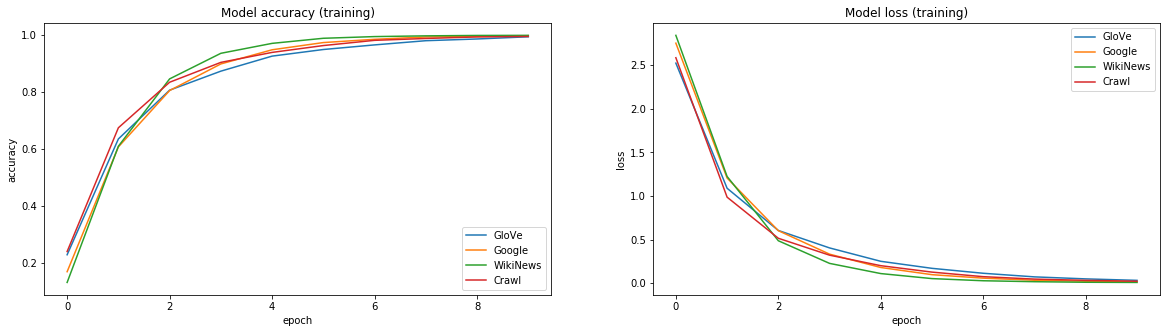

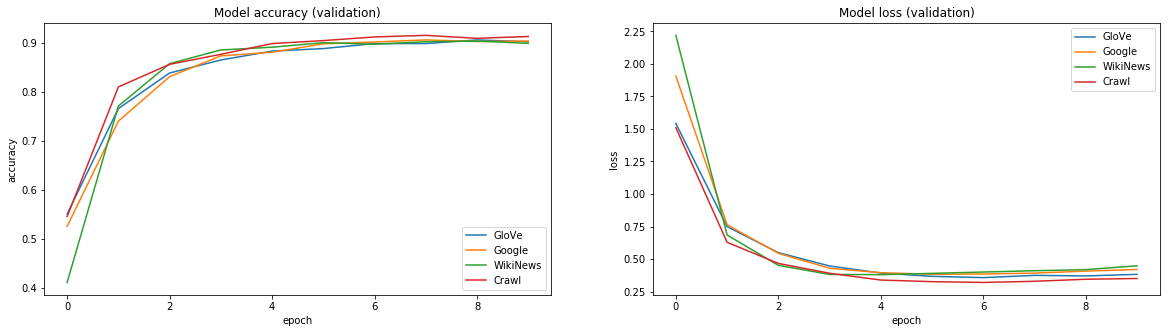

In [70]:
plot_acc_loss('training', history_10, 'acc', 'loss')
plot_acc_loss('validation', history_10, 'val_acc', 'val_loss')

Results of the models with 40 epochs

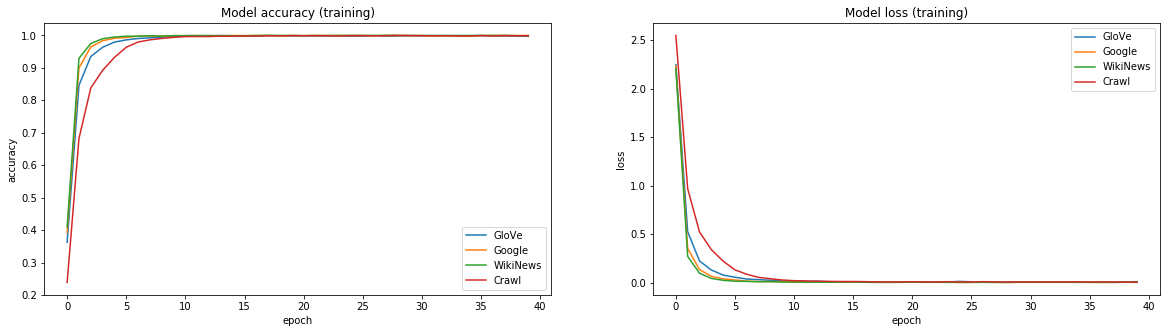

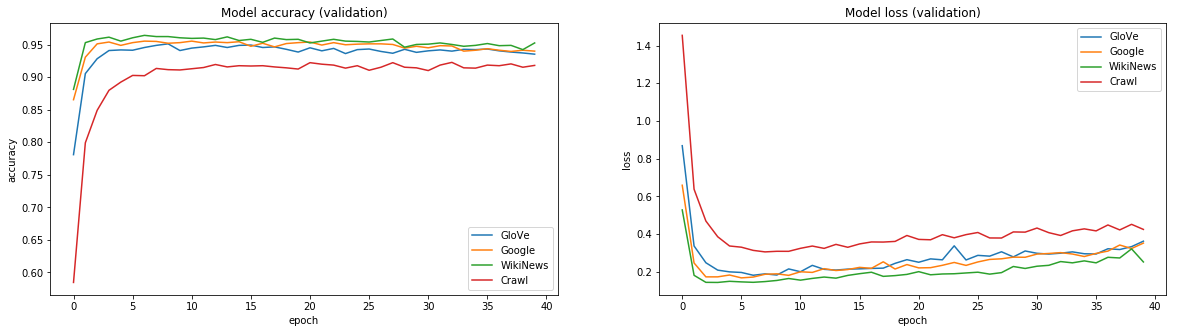

In [19]:
plot_acc_loss('training', history, 'acc', 'loss')
plot_acc_loss('validation', history, 'val_acc', 'val_loss')

## Testing of the model

As in the beggining, the testing files are loaded here and also the corresponding labels.

In [20]:
doc_test1 = read_files("./data/20news-bydate-test/alt.atheism")
doc_test2 = read_files("./data/20news-bydate-test/comp.graphics")
doc_test3 = read_files("./data/20news-bydate-test/comp.os.windows.misc")
doc_test4 = read_files("./data/20news-bydate-test/comp.sys.ibm.pc.hardware")
doc_test5 = read_files("./data/20news-bydate-test/comp.sys.mac.hardware")
doc_test6 = read_files("./data/20news-bydate-test/comp.windows.x")
doc_test7 = read_files("./data/20news-bydate-test/misc.forsale")
doc_test8 = read_files("./data/20news-bydate-test/rec.autos")
doc_test9 = read_files("./data/20news-bydate-test/rec.motorcycles")
doc_test10 = read_files("./data/20news-bydate-test/rec.sport.baseball")
doc_test11 = read_files("./data/20news-bydate-test/rec.sport.hockey")
doc_test12 = read_files("./data/20news-bydate-test/sci.crypt")
doc_test13 = read_files("./data/20news-bydate-test/sci.electronics")
doc_test14 = read_files("./data/20news-bydate-test/sci.med")
doc_test15 = read_files("./data/20news-bydate-test/sci.space")
doc_test16 = read_files("./data/20news-bydate-test/soc.religion.christian")
doc_test17 = read_files("./data/20news-bydate-test/talk.politics.guns")
doc_test18 = read_files("./data/20news-bydate-test/talk.politics.mideast")
doc_test19 = read_files("./data/20news-bydate-test/talk.politics.misc")
doc_test20 = read_files("./data/20news-bydate-test/talk.religion.misc")

X_test   = doc_test1 + doc_test2 + doc_test3 + doc_test4 + doc_test5 + doc_test6 + doc_test7 + doc_test8 + doc_test9 + \
    doc_test10 + doc_test11 + doc_test12 + doc_test13 + doc_test14 + doc_test15 + doc_test16 + doc_test17 + doc_test18 + doc_test19 + doc_test20
    
y_test = [0 for _ in range(len(doc_test1))] + [1 for _ in range(len(doc_test2))] + [2 for _ in range(len(doc_test3))] \
    + [3 for _ in range(len(doc_test4))] + [4 for _ in range(len(doc_test5))] + [5 for _ in range(len(doc_test6))] \
    + [6 for _ in range(len(doc_test7))] + [7 for _ in range(len(doc_test8))] + [8 for _ in range(len(doc_test9))] \
    + [9 for _ in range(len(doc_test10))] + [10 for _ in range(len(doc_test11))] + [11 for _ in range(len(doc_test12))] \
    + [12 for _ in range(len(doc_test13))] + [13 for _ in range(len(doc_test14))] + [14 for _ in range(len(doc_test15))] \
    + [15 for _ in range(len(doc_test16))] + [16 for _ in range(len(doc_test17))] + [17 for _ in range(len(doc_test18))] \
    + [18 for _ in range(len(doc_test19))] + [19 for _ in range(len(doc_test20))]

y_test = to_categorical(y_test)
print('Testing samples: %i' % len(X_test))

Testing samples: 7138


Tokenization of the sentences.

In [21]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

Import the models that were trained and saved before. Thanks to saving the models previously, there is no need of computing the models again after closing the notebook to test the models.

In [22]:
cnn_model_glove_10 = load_model("models/model_glove_10")
cnn_model_google_10 = load_model("models/model_google_10")
cnn_model_wikinews_10 = load_model("models/model_wikinews_10")
cnn_model_crawl_10 = load_model("models/model_crawl_10")

cnn_model_glove = load_model("models/model_glove")
cnn_model_google = load_model("models/model_google")
cnn_model_wikinews = load_model("models/model_wikinews")
cnn_model_crawl = load_model("models/model_crawl")

Compute the accuracy and loss value for the test data with the 10 epochs models.

In [25]:
scores_10 = []

score_glove_10 = cnn_model_glove_10.evaluate(X_test, y_test, verbose=1)
scores_10.append(score_glove_10)
print('Running test with the GloVe (10) model: %0.4f loss / %0.4f acc' % (score_glove_10[0], score_glove_10[1]))

score_google_10 = cnn_model_google_10.evaluate(X_test, y_test, verbose=1)
scores_10.append(score_google_10)
print('Running test with the Google\'s (10) model: %0.4f loss / %0.4f acc' % (score_google_10[0], score_google_10[1]))

score_wikinews_10 = cnn_model_wikinews_10.evaluate(X_test, y_test, verbose=1)
scores_10.append(score_wikinews_10)
print('Running test with the WikiNews (10) model: %0.4f loss / %0.4f acc' % (score_wikinews_10[0], score_wikinews_10[1]))

score_crawl_10 = cnn_model_crawl_10.evaluate(X_test, y_test, verbose=1)
scores_10.append(score_crawl_10)
print('Running test with the Crawl (10) model: %0.4f loss / %0.4f acc' % (score_crawl_10[0], score_crawl_10[1]))

7138/7138 [==============================] - 43s 6ms/step
Running test with the GloVe (10) model: 0.6311 loss / 0.8308 acc
7138/7138 [==============================] - 47s 7ms/step
Running test with the Google's (10) model: 0.6696 loss / 0.8232 acc
7138/7138 [==============================] - 44s 6ms/step
Running test with the WikiNews (10) model: 0.6481 loss / 0.8292 acc
7138/7138 [==============================] - 42s 6ms/step
Running test with the Crawl (10) model: 0.5848 loss / 0.8460 acc


Compute the accuracy and loss value for the test data with the 40 epochs models.

In [26]:
scores_40 = []

score_glove = cnn_model_glove.evaluate(X_test, y_test, verbose=1)
scores_40.append(score_glove)
print('Running test with the GloVe (40) model: %0.4f loss / %0.4f acc' % (score_glove[0], score_glove[1]))

score_google = cnn_model_google.evaluate(X_test, y_test, verbose=1)
scores_40.append(score_google)
print('Running test with the Google\'s (40) model: %0.4f loss / %0.4f acc' % (score_google[0], score_google[1]))

score_wikinews = cnn_model_wikinews.evaluate(X_test, y_test, verbose=1)
scores_40.append(score_wikinews)
print('Running test with the WikiNews (40) model: %0.4f loss / %0.4f acc' % (score_wikinews[0], score_wikinews[1]))

score_crawl = cnn_model_crawl.evaluate(X_test, y_test, verbose=1)
scores_40.append(score_crawl)
print('Running test with the Crawl (40) model: %0.4f loss / %0.4f acc' % (score_crawl[0], score_crawl[1]))

7138/7138 [==============================] - 41s 6ms/step
Running test with the GloVe (40) model: 0.7073 loss / 0.8359 acc
7138/7138 [==============================] - 41s 6ms/step
Running test with the Google's (40) model: 0.7907 loss / 0.8273 acc
7138/7138 [==============================] - 42s 6ms/step
Running test with the WikiNews (40) model: 0.7174 loss / 0.8298 acc
7138/7138 [==============================] - 41s 6ms/step
Running test with the Crawl (40) model: 0.5917 loss / 0.8409 acc


In the next cell a function is defined, able to show a barchar with the given values, in order to compare the values of the models.

In [43]:
def show_barchar(title, y_label, values_10, values_40):

    ind = np.arange(len(values_10))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, values_10, width,
                    color='SkyBlue', label='10 Epochs')
    rects2 = ax.bar(ind + width/2, values_40, width,
                    color='IndianRed', label='40 Epochs')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(('Glove', 'Google', 'WikiNews', 'Crawl'))
    ax.legend()

    plt.show()

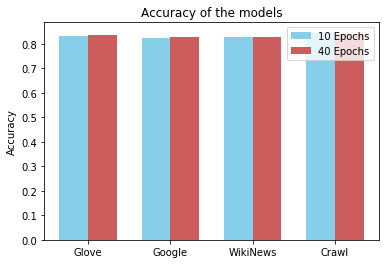

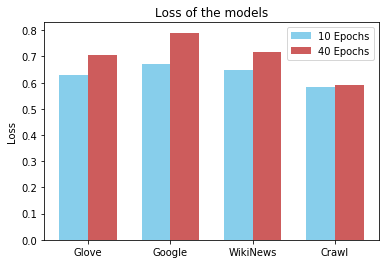

In [46]:
show_barchar('Accuracy of the models', 'Accuracy', [s[1] for s in scores_10], [s[1] for s in scores_40])
show_barchar('Loss of the models', 'Loss', [s[0] for s in scores_10], [s[0] for s in scores_40])

## Results and conclusion

The conclusion of the results that we obtain here is that the training in 40 epochs is not worth the time, since the ones with the 10 epochs give better performance and loss values. In addition, we can see that the model with 40 eopchs is suffering of overfitting, because of the excess of epochs. The models with 40 epochs are memorizing the training data and this difficutls the generalization. More information about this can be found in the corresponding report.

The performance of the models is very good, so we can say that the convolutional neural networks can be used in text analysis and classification with no problem.